In [15]:
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow_examples.lite.model_maker.core.export_format import ExportFormat
from tensorflow_examples.lite.model_maker.core.task import image_preprocessing

from tflite_model_maker import image_classifier
from tflite_model_maker import ImageClassifierDataLoader
from tflite_model_maker.image_classifier import ModelSpec

2023-05-17 03:57:52.227457: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-17 03:57:52.227493: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/ubuntu/myenv/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/myenv/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some t

In [16]:
# Retrieve the cassava plant disease dataset and splits into training, validation and test datasets

tfds_name = 'cassava'
# tfdsload function is used to load the dataset cassava as well as the splits to load 
(ds_train, ds_validation, ds_test), ds_info = tfds.load(
    name=tfds_name,
    split=['train', 'validation', 'test'],
    with_info=True,
    # loads the dataset in a format that can be used for supervised learning 
    as_supervised=True)
TFLITE_NAME_PREFIX = tfds_name

2023-05-17 03:58:03.215284: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-17 03:58:03.215328: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-17 03:58:03.215358: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-2-181): /proc/driver/nvidia/version does not exist
2023-05-17 03:58:03.218305: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
# Construct the list of labels and loads the training and validation datasets

label_names = ds_info.features['label'].names

train_data = ImageClassifierDataLoader(ds_train,
                                       ds_train.cardinality(),
                                       label_names)
validation_data = ImageClassifierDataLoader(ds_validation,
                                            ds_validation.cardinality(),
                                            label_names)

# This selects the name of the model to use (mobilenet v3)

model_name = 'mobilenet_v3_large_100_224' 

# this maps specific model name to the URLs for their crresponding pre-trained weights to the tensorflow hub 
map_model_name = {
    'cropnet_cassava':
        'https://tfhub.dev/google/cropnet/feature_vector/cassava_disease_V1/1',
    'cropnet_concat':
        'https://tfhub.dev/google/cropnet/feature_vector/concat/1',
    'cropnet_imagenet':
        'https://tfhub.dev/google/cropnet/feature_vector/imagenet/1',
    'mobilenet_v3_large_100_224':
        'https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5',
}

model_handle = map_model_name[model_name]

image_model_spec = ModelSpec(uri=model_handle)

In [18]:
# Build the model by training the model with the training dataset

model = image_classifier.create(
    train_data,  # train_data: the training data, which should be a tf.data.Dataset object containing labeled images
    model_spec=image_model_spec,
    batch_size=64,  # the number of images to be processed in each batch during training.
    learning_rate=0.03, # the learning rate used by the optimizer during training.
    epochs=1, #the number of times to iterate over the entire training dataset during training.
    shuffle=True, # If True, all layers of the model are trainable
    train_whole_model=True,  # if False, only the classification layer is trainable.
    validation_data=validation_data)

# model.model.save('/tmp/my_model.h5')
# s3.upload_file('/tmp/my_model.h5', buket, object_key)

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             4226432   
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 4,232,837
Trainable params: 4,208,437
Non-trainable params: 24,400
_________________________________________________________________
None
88/88 [==============================] - 644s 7s/step - loss: 1.2095 - accuracy: 0.7404 - val_loss: 1.1801 - val_accuracy: 0.7771


In [19]:
# This is a mapping dictionary of the disease codes to names

name_map = dict(
    cmd='Mosaic Disease',
    cbb='Bacterial Blight',
    cgm='Green Mite',
    cbsd='Brown Streak Disease',
    healthy='Healthy',
    unknown='Unknown')

[(name_map[x],x) for x in label_names]

[('Bacterial Blight', 'cbb'),
 ('Brown Streak Disease', 'cbsd'),
 ('Green Mite', 'cgm'),
 ('Mosaic Disease', 'cmd'),
 ('Healthy', 'healthy')]

In [20]:
# Use the trained model to make predictions off the standard test dataset split from cassava 

test_data = ImageClassifierDataLoader(ds_test, ds_test.cardinality(),
                                      label_names)
model.predict_top_k(test_data)

[[('cmd', 0.4356)],
 [('cmd', 0.8929594)],
 [('cgm', 0.51382494)],
 [('cgm', 0.4015458)],
 [('cmd', 0.75532204)],
 [('cmd', 0.92700016)],
 [('cmd', 0.94323015)],
 [('cmd', 0.6184537)],
 [('cgm', 0.9125807)],
 [('cgm', 0.43547595)],
 [('cmd', 0.9610083)],
 [('cmd', 0.86980605)],
 [('cmd', 0.7030274)],
 [('cbsd', 0.97631353)],
 [('cmd', 0.92883027)],
 [('cmd', 0.8014419)],
 [('cgm', 0.9397378)],
 [('cmd', 0.90680027)],
 [('cmd', 0.8828965)],
 [('cmd', 0.7951717)],
 [('cbsd', 0.80610186)],
 [('cbsd', 0.7246023)],
 [('healthy', 0.8253644)],
 [('cbsd', 0.8625861)],
 [('cbsd', 0.9453035)],
 [('cgm', 0.9553615)],
 [('cbsd', 0.97195137)],
 [('cgm', 0.6319415)],
 [('cmd', 0.5814304)],
 [('cbsd', 0.403145)],
 [('cmd', 0.6584167)],
 [('cmd', 0.8276526)],
 [('cbsd', 0.88600504)],
 [('cmd', 0.9391625)],
 [('cmd', 0.8494285)],
 [('cbsd', 0.9676325)],
 [('cmd', 0.80872256)],
 [('cbsd', 0.97036594)],
 [('cmd', 0.84716725)],
 [('cmd', 0.7753852)],
 [('cmd', 0.72740793)],
 [('cmd', 0.87454164)],
 [('cmd

In [21]:
# Retrieve the image files from Amazon S3
import boto3
import io
# loading the the downloaded images as Numpy arrays 
import matplotlib.image as mpimg

# Read the bucket name from input.log, used to create or update a table with same name
with open('/home/ubuntu/ML/input.log', 'r') as file:
    bucket_name = file.read().replace('\n', '')

# boto3 resource using default credentials in .aws
s3 = boto3.resource('s3', region_name='us-west-2')

# the bucket that triggered the lambda based on the timestamp upload event
bucket = s3.Bucket(bucket_name)

s3_client = boto3.client('s3', region_name='us-west-2')
# Get the contents of the time_stamp.txt object in the bucket
timestamp_obj = s3_client.get_object(Bucket=bucket_name, Key='time_stamp.txt')
timestamp = timestamp_obj['Body'].read().decode('utf-8').strip()

# ses setup
email_client = boto3.client("ses", region_name="us-west-2")

# dict for storing images
images = {}

# list for storing each plant_id
plant_ids = []

# get all objects from the bucket
summaries = bucket.objects.all()

# loop through all objects in the bucket
for f in summaries:
    # BytesIO object holds image data
    bstream = io.BytesIO()

    # check if the current object is a JPEG
    if str(f.key).upper().endswith(".JPG") or str(f.key).upper().endswith(".JPEG"):
        # download image into the BytesIO object
        bucket.Object(f.key).download_fileobj(bstream)

        # read image data and store it in the images dict
        images[f.key] = mpimg.imread(bstream, format="JPEG")
        # extract the number from the image file name, file name will always be formatted as "Plant_{N}", where {N} is any number
        plant_id = f.key.split('_')[1].split('.')[0] # split the string on the underscore, split the remaining string on the dot, select the string before the dot 
        plant_ids.append(plant_id)
        print(f"{f.key}, id = {plant_id}, current # of id's = {len(plant_ids)}")

Plant_10.JPG, id = 10, current # of id's = 1
Plant_11.JPG, id = 11, current # of id's = 2
Plant_12.JPG, id = 12, current # of id's = 3
Plant_13.JPG, id = 13, current # of id's = 4
Plant_14.JPG, id = 14, current # of id's = 5
Plant_15.JPG, id = 15, current # of id's = 6
Plant_16.JPG, id = 16, current # of id's = 7
Plant_9.JPG, id = 9, current # of id's = 8


In [22]:
# Construct a new dataset using my image files 
v = [x for x in images.values() if x.shape[0] == 256 and x.shape[1] == 256] #list(images.values())

input_1 = np.array(v) #np.array(list(images.values())) #np.array((img1, img2))
input_2 = np.array([0]*len(v)) #np.array((0, 0))

ds_test2 = tf.data.Dataset.from_tensor_slices((input_1, input_2))

#tf.data.Dataset.from_tensor_slices([img1, img2])
test_data2 = ImageClassifierDataLoader(ds_test2, ds_test2.cardinality(),
                                      label_names)


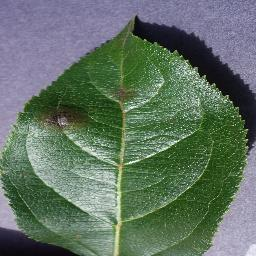

('Green Mite', 0.4123086631298065)


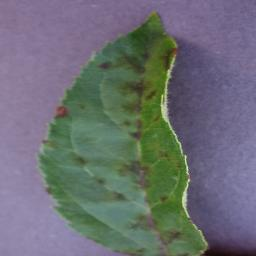

('Bacterial Blight', 0.4292239248752594)


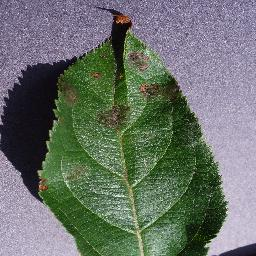

('Bacterial Blight', 0.3496738374233246)


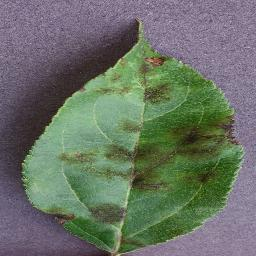

('Mosaic Disease', 0.6597227454185486)


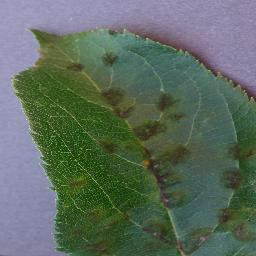

('Brown Streak Disease', 0.5499946475028992)


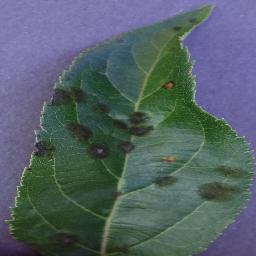

('Brown Streak Disease', 0.5287573933601379)


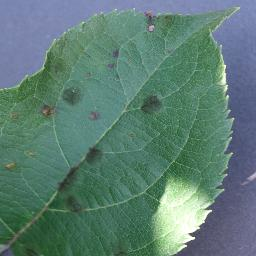

('Bacterial Blight', 0.43186917901039124)


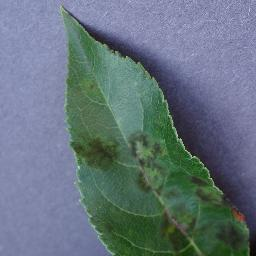

('Mosaic Disease', 0.7399524450302124)


In [23]:
# Show the images 
from PIL import Image as im

# Predict whether the images have disease
# Returns (label, probability)
labels = [(name_map[x[0][0]], float(x[0][1])) for x in model.predict_top_k(test_data2)]

i=0
for d in ds_test2:
    display(im.fromarray(d[0].numpy()))
    print(labels[i])
    i+=1

In [25]:
from decimal import Decimal
from boto3.dynamodb.conditions import Key
from botocore.exceptions import ClientError

# dynamodb setup
dynamodb = boto3.resource('dynamodb', region_name='us-west-2')
table_name = bucket_name  # use the bucket_name as table_name

# check if table exists
try: 
    table = dynamodb.create_table(
        TableName=table_name,
        KeySchema=[
            {
                'AttributeName': 'plant_id',
                'KeyType': 'HASH' # this makes plant_id essentially the primary key
            }
        ],
        AttributeDefinitions=[
            {
                'AttributeName': 'plant_id',
                'AttributeType': 'S'
            }
        ],
        ProvisionedThroughput={
            'ReadCapacityUnits': 10,
            'WriteCapacityUnits': 10
        }
    )
    
    # wait until the table is created
    table.meta.client.get_waiter('table_exists').wait(TableName=table_name)
    print(f"Created {table_name} table")
except ClientError as ce:
    if ce.response['Error']['Code'] == "ResourceInUseException":
        print(f"Table {table_name} already exists")
        table = dynamodb.Table(table_name)
    else:
        print(f"Unknown exception occurred while querying for {table_name} table")
        print(ce)
        
# Get the labels for the test data using the trained model
disease = True

for plant_id, (label, probabilities) in zip(plant_ids, labels):
    if label == "Healthy":
        diseased = False
        
    # check if the item exists in the table
    response = table.query(
        KeyConditionExpression=Key('plant_id').eq(plant_id)
    )
    items = response['Items']
    
    # table has matching items already
    if items:
        # update existing item
        item = items[0]
        item["metadata"].append(
            {
                "disease": label,
                "probability": Decimal(str(probabilities)),  
                "time_stamp": timestamp
            }
        )
        table.put_item(Item=item)
    else:
        # no existing item found, create one with new plant_id
        item = {
            "plant_id": plant_id,
            "metadata": [
                {
                   "probability": Decimal(str(probabilities)),
                    "time_stamp": timestamp 
                }
            ]
        }
        table.put_item(Item=item)
    
    # body_data = str(garden_id) + " - " + label + " detected"
    # body_page = """
    #     <html>
    #     <head></head>
    #     <body>
    #     <h2>Disease Detected - """ + label + """</h2>""" + """
    #     <p>Found in GardenId = """ + str(garden_id) + """
    #     </body>
    #     </html> """
    # if diseased:
    #     try:
    #         email_client.send_email(Source="ttsega03@gmail.com", 
    #                                Destination={
    #                                    "ToAddresses": [
    #                                        "mesteddy14@gmail.com"
    #                                    ]
    #                                }, Message={
    #                                    "Subject": {
    #                                        "Data": "Disease Detected",
    #                                        "Charset": "UTF-8"
    #                                    },
    #                                    "Body": {
    #                                        "Text": {
    #                                            "Data": body_data,
    #                                            "Charset": "UTF-8"
    #                                        },
    #                                        "Html": {
    #                                            "Data": body_page,
    #                                            "Charset": "UTF-8"
    #                                        }
    #                                    }
    #                                }
    #                                )
    #     except Exception as e:
    #         print(e)
    # garden_id += 1
    print("done!")

Table benvc3 already exists
done!
done!
done!
done!
done!
done!
done!
done!
